# Working with FITS images in Python #

### ASTRON 441 ###

Y. Dong (Northwestern) \
October, 2022

Hi. The purpose of this script is to familiarize an user on how to work with FITS files in Python. Specifically, this code is intend to not only be user-friendly, but also allows fellow astronomers (even theorists!) to: 
1. Read in any FITS image (optical & radio)
2. Create cutouts of your FITS image
3. Add regions on the FITS image

I hope you find it helpful in any way! If you do end up using this script, please cite it through: https://ascl.net/. 
Happy open-source coding :)

### Pixel Scale ###

Different images have different pixel scales. To put it simply, it tell you how many arcseocnds is in a single pixel on an image. The smaller this number is, the better the resolution tends to be because that means the image contains more details. For example, a HST image usually has a pixel scale of 0.03 "/pix. 

There are many ways to obtain the pixel scale of a FITS image. It is usually given by the parameter `CDELT2` in the header in units of degrees. If that is not provided, then a quik way to do so is to grab `CD2_1` and `CD2_2` from the header. Then, Pixel scale in arcseconds is: 

$\sqrt{(CD2\_1)^2 + (CD2\_2)^2} \times 3600$.

### What does the code do here? ###

The code below will first read in the FITS file, then create a cutout based on how big you would like it to be, all in one go!

One little caveat, Sometimes the images could look a bit lopsides if it's not in the "Correct" orientation, meaning N up and E to the left. That generally is fine and is really only an issue for optical images, but if you want to orient it the right way, you may have a couple more extra steps to do. But for the purpose of this script, we will not worry about that.

In [1]:
import numpy as np, os
import warnings 
warnings.filterwarnings('ignore')
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS; from astropy.io import fits
from astropy.nddata import Cutout2D; from astropy import units
from astropy.coordinates import SkyCoord

In [2]:
def image(FITS, wavelength, ra, dec, imsize):
    myFITS = FITS # name of the FITS image
    image = get_pkg_data_filename(myFITS)

    # This is your header dictionary!
    hdr = fits.getheader(myFITS)

    # Opening up our fits image as a Header Data Unit, and it's usually the first axis in a FITS file.
    # It's also called a primary array. 
    # If it's not the first one, try the second one... i.e. [1] instead of [0]
    hdu = fits.open(image)[0]
    
    # The way data is formated is a bit different in radio images, thus we use the squeeze() function to 
    # remove single-dimensional entries from the shape of the array
    if wavelength == 'radio':
        image_data = hdu.data.squeeze() 
    
    # Grabbing WCS coordinates from the header
    wcs = WCS(hdu.header).celestial
    
    # This is your pixel scale in "/pix
    if hdr['CDELT2'] != 0:
        pixelscale = hdr['CDELT2'] * 3600
    elif hdr['CD2_1'] and hdr['CD2_2'] != 0 :
        pixelscale = np.sqrt(hdr['CD2_1']**2 + hdr['CD2_2']**2) * 3600
    else:
        print('You do not have a pixel scale yet!')

    # Set image size, first in arcseconds, then convert to pixels
    n = imsize # how many arcseconds?
    npix = round(n/pixelscale); onearcsec = 1/pixelscale

    # Now, we will create an n x n arcsec image, centered around the object of interest
    bounds = int(npix/2)
    
    # Your object coordinates
    obj_ra = ra
    obj_dec = dec

    coord = '{} {}'.format(obj_ra, obj_dec)
    coord = SkyCoord(coord, frame='fk5', unit=(units.hourangle, units.deg))

    # Where is the pixel location of the object coordinates? This is for plotting, but it's not needed for the cutout
    # Note, we are using wcs here to do so, it's a very powerful tool!
    pixel_coord = wcs.wcs_world2pix(coord.ra, coord.dec, 0)

    # Rounding the pixel coords, this is again, for when we plot this image later on
    objra, objdec = round(float(pixel_coord[0])), round(float(pixel_coord[0]))
    
    # Making the cutout, exciting! 
    if wavelength == 'optical':
        cutout = Cutout2D(hdu.data, coord, n*units.arcsec, wcs=wcs)
    elif wavelength == 'radio':
        cutout = Cutout2D(image_data, coord, n*units.arcsec, wcs=wcs)
        
    # Need to adjust the wcs coordinates to the cutout!
    hdr_cutout = cutout.wcs.to_header()
    
    return cutout, hdr_cutout, pixelscale


### Example ###

This is a really pretty galaxy called NGC4321. I took the g-band image from PanSTARRS-1 Image Archive (http://ps1images.stsci.edu/cgi-bin/ps1cutouts)

If you like to try out a radio image, I recommend looking through CIRADA (http://cutouts.cirada.ca/). A cool object would be the radio galaxy Cygnus A.

In [3]:
mycutout, hdr, pixelscale  = image('NGC4321_g.fits', 'optical', '12:22:54.831', '+15:49:18.54', imsize=200)
#mycutout, hdr, pixelscale  = image('NVSS_CygnusA.fits', 'radio', '19:59:28.3565', '+40:44:02.097', imsize=600)

### Saving the cutout ###

you can very much stop here and just save out the cutout image if you like. The lines below will simpy take all of the data stored in cutout and save it out as a FITS file with the physical size you specified. Give it a go! 

In [4]:
img_hdu = fits.PrimaryHDU(mycutout.data, header=hdr)
img_hdu_list = fits.HDUList([img_hdu]) # create new hdulist
img_hdu_list.writeto('cutout_optical.fits', overwrite=True) # writing it to a FITS file

### If all you want is just a cutout of your image, then you are done here! Enjoy your new image! ###

What follows is a quick tutorial on how you can throw down regions on your images at a specified position. Fair warning, there are things you may need to pip install in order for it to fully function. But, if you are willing to go the extra mile, then the script should be very helpful for you.

In [5]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import ZScaleInterval, MinMaxInterval, PercentileInterval

Below, `norm` and `mean, med, sigma` decide the stretch of the image and make the regions we are planning to put on the image. If you want to change the contrast to bring out different features in the image, you can adjust `vmin` and `vmax` just a couple lines down.

Here, I am demonstrating how you can add a position, an ellipse, and some text to your cutout. But first, there are a few things you will need:
1. **Coordinates of where you want to put the regions**
2. **For ellipses: semi-minor axis, semi-major axis, and the position angle**

the text is added using `plt.annotate`. For more information, see documentation here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html

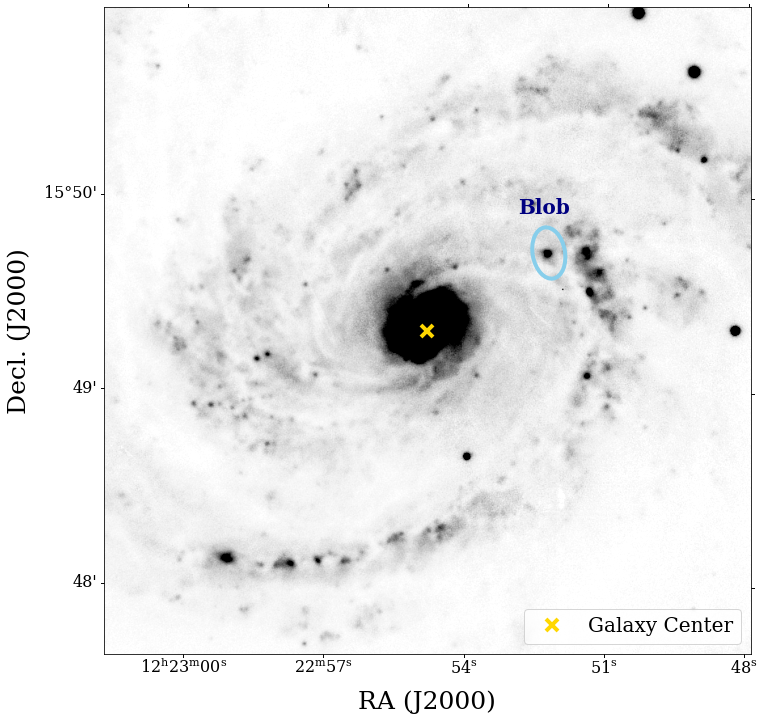

In [6]:
# This is just the font I personally like
plt.rcParams['font.family'] = 'serif'

# This normalizes your image to Zscale. There are other scales you can use though!
norm = ImageNormalize(mycutout.data, interval=ZScaleInterval())

# This finds the mean, median, and sigma of the flux of your image
mean, med, sigma = sigma_clipped_stats(mycutout.data)

figsize = 14 # size of figure in inches

#### DEFINE REGION 1 (position)
reg_ra_wcs = '12:22:54.831'
reg_dec_wcs = '+15:49:18.54'
reg_coord_wcs = '{} {}'.format(reg_ra_wcs, reg_dec_wcs)
coordreg_wcs = SkyCoord(reg_coord_wcs, frame='fk5', unit=(units.hourangle, units.deg))

# Finds the pixel locations of the region coordinates
reg_pos_pix = mycutout.wcs.wcs_world2pix(coordreg_wcs.ra, coordreg_wcs.dec, 0)

# Splits array into two separate variable names
reg_ra_pix, reg_dec_pix = float(reg_pos_pix[0]), float(reg_pos_pix[1])


#### DEFINE REGION 2 (ellipse)
arcperpixel = pixelscale

reg_ra_wcs_ellipse = '12:22:52.2557'
reg_dec_wcs_ellipse = '+15:49:42.653'
reg_coord_wcs_ellipse = '{} {}'.format(reg_ra_wcs_ellipse, reg_dec_wcs_ellipse)
coordreg_wcs = SkyCoord(reg_coord_wcs_ellipse, frame='fk5', unit=(units.hourangle, units.deg))

# Finds the pixel locations of the region coordninates
reg_pos_pix_ellipse = mycutout.wcs.wcs_world2pix(coordreg_wcs.ra, coordreg_wcs.dec, 1)

# Splits array into two separate variable names
reg_ra_pix_ellipse, reg_dec_pix_ellipse = float(reg_pos_pix_ellipse[0]), float(reg_pos_pix_ellipse[1])

# Note these lines has to be moved to after the ax.imshow command if using Jupyter.
a=8 #localization RA radius in arcsec, semi-major axis
b=5 #localization Dec radius in arcsec, semi-minor axis 
pos_angle= 100 #defined as E of N, the way it works in Python, you have to add 90 degress to the angle

a_pix=(a*2)/arcperpixel #RA diameter in pixels
b_pix=(b*2)/arcperpixel #Dec diameter in pixels
pos_angle_ellipse=pos_angle #Transformation to python's way of defining ellipse

# The final ellipse 'patch' you will add to your image
e2=patches.Ellipse((reg_ra_pix_ellipse,reg_dec_pix_ellipse),a_pix,b_pix,angle=pos_angle_ellipse,linewidth=4,fill=False, color='skyblue')


##################### Let's make the figure! #####################
# figsize specifies x, y dimensions, we are plotting the wcs coords here too! 
fig, ax = plt.subplots(1, figsize=(figsize,0.85*figsize),subplot_kw={'projection':mycutout.wcs})

# Adjust vmin and vmax as needed to get desired effect
vmin=med-1*sigma 
vmax=med+10*sigma 

# Aesthetics 
ax.tick_params(axis='both', labelsize=16)

# Axes 
ax.set_xlabel('RA (J2000)', fontsize=25)
ax.set_ylabel('Decl. (J2000)', fontsize=25)

# Plotting a cross (region 1)
ax.plot(reg_ra_pix,reg_dec_pix,marker='x',color='gold',markersize=12, markeredgewidth=4, label='Galaxy Center', ls='None')

# Adding our patch of the ellipse (region 2)
ax.add_patch(e2)

# Add your text! (region 3), x and y are the xy-coordinates which determines the position of your text
ax.annotate('Blob',xy=(0.72,0.68), xycoords='axes fraction', color='navy', fontsize=20, horizontalalignment='right', fontweight='bold')

# Showing your image here! You can adjust the cmap however you like! 
ax.imshow(mycutout.data, cmap='Greys', norm=norm, vmin=vmin, vmax=vmax) 

ax.legend(fontsize=20, loc='lower right', frameon=True)

# Uncomment this if you want to save this image! 
#plt.savefig('cutout_regions.png', dpi=200)